In [1]:
# Importing Module

In [3]:
#kplr used to import koi data easier
import kplr
client = kplr.API()

#used to open .fits files
import pyfits

#Another possible way to plot with interactive plots
from bokeh.plotting import figure, show, output_file,output_notebook
#Allows for viewing of plots on jupyter notebooks
# BOKEH_RESOURCES=inline
# output_notebook()

#For Maximum Likelihood
from scipy import optimize

#Used for scientific computing
import numpy as np

#For making copies of data
import copy

#Needed to correct median with 'nan' data points
import math

#For Periodogram
from gatspy.periodic import LombScargleFast

#Importing and notebook setup
%matplotlib inline

#For Plotting
import matplotlib.pyplot as plt

#adjusting data using pyke
import pyke

#for astro constants
from astropy.constants import *

import astropy.units as units

#needed for bls function
import math

#median
import statistics

#box least square module
import bls

#used to model fit of light curve
import batman

#also used to model fit
# from pytransit import MandelAgol

# Making useful functions

Removing "nan" Flux Data Points

In [4]:
###Removes nan data points
def remove_nan(datax,datay,yerr):
    #array of nan points location in flux array
    nan_points=np.array([])
    
    #finds points that have nan as data point
    for j in range(0,len(datax)-1):
        if math.isnan(datay[j])==True:
            nan_points = np.append(nan_points,j)
            
    #deletes the points with nan and correspoding time
    datax = np.delete(datax,nan_points)
    datay = np.delete(datay,nan_points)
    yerr = np.delete(yerr,nan_points)
        
    return(datax,datay,yerr)

Median Smooth

In [5]:
### Median Smooth the flux of a star
#time - time data
#flux - flux data
#interval - number of data to smooth over for each step
def median_smooth(time,flux,interval,flux_err):    
    x = 0
    f_q = copy.copy(flux)
    #removing nan values
    t_q,f_q,fe_q= remove_nan(time,f_q,flux_err)
    f_sort=f_q[0:interval]
    
    while x+2< len(f_q)-3:
        f_sort = np.sort(f_q[x:x+interval]) #sort data min to max
        f_median = statistics.median(f_sort) #find median
        
        #median smoothing flux error
        fe_sort = np.sort(fe_q[x:x+interval]) #sort data min to max
        fe_median = statistics.median(fe_sort) #find median
        
        if f_q[2+x] > f_median:#only changes if median is greater than point being changed
            f_q[2+x] = f_median #replace value with median
            fe_q[2+x] = fe_median #replacing value with flux error
        x = x+1
    
    return (t_q,f_q,fe_q)

Detrending Function

In [6]:
def detrend(t_norm,f_norm,ferr_norm):
    #finding the running average interval(needs to be odd number)
    npts = int(len(f_norm))
    n = int(np.sqrt(npts))
    if int(np.sqrt(npts))%2 ==0:
         n=n+1
            
    #making copy to get running avg       
    c = copy.copy(f_norm)
    ce = copy.copy(ferr_norm)


    #Finding running avg vector
    for i in range(0,len(f_norm)-(n)+1):
        low_r = i #lower range
        high_r = low_r + n #upper range
        center = i + (n+1)/2 #center of interval
        data = f_normalized[low_r:high_r] #interval of data
        #running = np.mean(data,dtype=np.float64) #running average
        running = np.float64( "%f" % np.median(data)) #for running median

        c[center] = running #copying average to center of interval point

        
    #doesn't change the first (n+1)/2 and last (n+1)/2 points
    low_r = (n+1)/2 #first point changed 
    high_r = len(f_norm)-low_r #last point changed
    f_detrend = 1+(f_norm[low_r:high_r]- c[low_r:high_r])#final array has n less points
    t_detrend = t_norm[low_r:high_r]#corresponding time 
    ferr_detrend = ferr_norm[low_r:high_r]#corresponding time 

    
    return (t_detrend,f_detrend,ferr_detrend)

Periodograms

In [7]:
###Lomb-Scargle Periodogram

# Used to find periodic activity of star 
### Works only if you remove "nan" data points
#datax - time data
#datay - flux data
#min_per - range minimum for finding period
#max_per -  range maximum for finding period
#nyquist -  time between data points
def periodogram(datax, datay, min_per, max_per, nyquist):
    #finding periodogram
    model = LombScargleFast().fit(datax, datay)
    period, power = model.periodogram_auto(nyquist_factor=nyquist)
    
    #plotting
    x_label = 'Period'
    y_label = 'Power'
    title = 'Lomb-Scargle Periodogram'
    
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.semilogx(period,power)

    # set range and find period
    model.optimizer.period_range=(min_per, max_per)
    period = model.best_period
    print("period = {0}".format(period))
    return period

BLS Function

In [8]:
#### Copying code from: https://ridlow.wordpress.com/category/ipython-notebook/

# t - time is an N-dimensional array of timestamps for the light curve,
# x - flux is the N-dimensional light curve array,
# qmi is the minimum transit duration to test, and
# qma is the maximum transit duration to test.
# fmin is the minimum frequency to test,
# df is the frequency grid spacing,
# nb is the number of bins to use in the folded light curve,
# nf is the number of frequency bins to test,

def func_bls(t, x, qmi, qma, fmin, df, nf, nb):
    """Frist trial, BLS algorithm, only minor modification from author's code"""
    
    n = len(t); rn = len(x)
    #! use try
    if n != rn:
        print "Different size of array, t and x"
        return 0

    rn = float(rn) # float of n

    minbin = 5
    nbmax = 2000
    if nb > nbmax:
        print "Error: NB > NBMAX!"
        return 0

    tot = t[-1] - t[0] # total time span

    if fmin < 1.0/tot:
        print "Error: fmin < 1/T"
        return 0

    # parameters in binning (after folding)
    kmi = int(qmi*nb) # nb is number of bin -> a single period
    if kmi < 1: 
        kmi = 1
    kma = int(qma*nb) + 1
    kkmi = rn*qmi # to check the bin size
    if kkmi < minbin: 
        kkmi = minbin

    # For the extension of arrays (edge effect: transit happen at the edge of data set)
    nb1 = nb + 1
    nbkma = nb + kma
        
    # Data centering
    t1 = t[0]
    u = t - t1
    s = np.mean(x) # ! Modified
    v = x - s

    bpow = 0.0
    p = np.zeros(nf)
    # Start period search
    for jf in range(nf):
        f0 = fmin + df*jf # iteration in frequency not period
        p0 = 1.0/f0

        # Compute folded time series with p0 period
        ibi = np.zeros(nbkma)
        y = np.zeros(nbkma)
        for i in range(n):
            ph = u[i]*f0 # instead of t mod P, he use t*f then calculate the phase (less computation)
            ph = ph - int(ph)
            j = int(nb*ph) # data to a bin 
            ibi[j] = ibi[j] + 1 # number of data in a bin
            y[j] = y[j] + v[i] # sum of light in a bin
        
        # Extend the arrays  ibi()  and  y() beyond nb by wrapping
        for j in range(nb1, nbkma):
            jnb = j - nb
            ibi[j] = ibi[jnb]
            y[j] = y[jnb]

        # Compute BLS statictics for this trial period
        power = 0.0

        for i in range(nb): # shift the test period
            s = 0.0
            k = 0
            kk = 0
            nb2 = i + kma
            # change the size of test period (from kmi to kma)
            for j in range(i, nb2): 
                k = k + 1
                kk = kk + ibi[j]
                s = s + y[j]
                if k < kmi: continue # only calculate SR for test period > kmi
                if kk < kkmi: continue # 
                rn1 = float(kk)
                powo = s*s/(rn1*(rn - rn1))
                if powo > power: # save maximum SR in a test period
                    power = powo # SR value
                    jn1 = i # 
                    jn2 = j
                    rn3 = rn1
                    s3 = s

        power = math.sqrt(power)
        p[jf] = power

        if power > bpow:
            bpow = power # Save the absolute maximum of SR
            in1 = jn1
            in2 = jn2
            qtran = rn3/rn
            # depth = -s3*rn/(rn3*(rn - rn3))
            # ! Modified
            high = -s3/(rn - rn3)
            low = s3/rn3
            depth = high - low
            bper = p0
    
    # ! add
    sde = (bpow - np.mean(p))/np.std(p) # signal detection efficiency

    return bpow, in1, in2, qtran, depth, bper, sde, p, high, low

# Beginning to Look at Data

Importing Data

In [98]:
# Find a KOI.
koi = client.koi(265.01)

#Download the lightcurves for this KOI.
lightcurves = koi.get_light_curves(short_cadence=False)
# for lc in lightcurves:
#     print (lc.filename)
print "Kepler ID ", koi.kepid
print koi.star.kic_teff

Kepler ID  12024120
6032


Getting Like Curve Data

In [99]:
#Loop over the datasets and read in the data.
#Open the FITS data file and return the ``pyfits.HDUList``. This will
#download the file if it isn't already saved locally.
datacol = "PDCSAP_FLUX"
errcol = "PDCSAP_FLUX_ERR"
time, flux, ferr, quality = [], [], [], []
for lc in lightcurves:
    with lc.open() as f:
        # The lightcurve data are in the first FITS HDU.
        #can also append "SAP_Flux"
        hdu_data = f[1].data
        time.append(hdu_data["time"])
        flux.append(hdu_data[datacol])
        ferr.append(hdu_data[errcol])
        quality.append(hdu_data["sap_quality"])

Initial Plot of Data

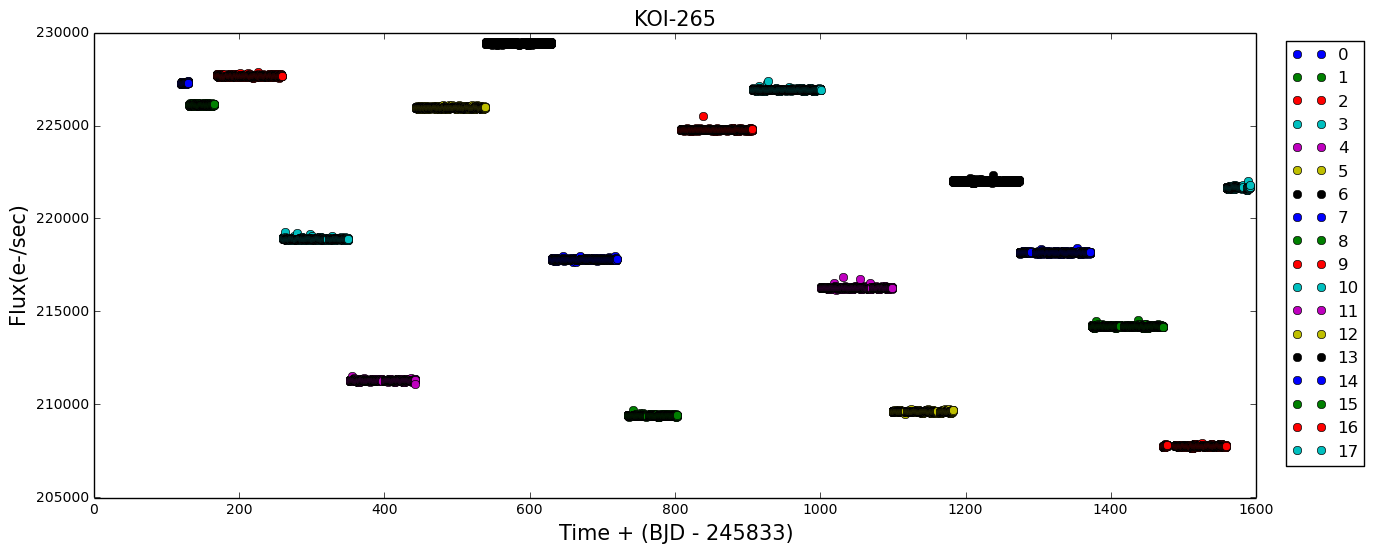

In [114]:
#Time (BJD - 2454833)
#Flux (e-/sec)
#Which range of quarters do you want to look at?
q_l = 0
q_h = 17
quarters = np.linspace(q_l,q_h,q_h+1-q_l,dtype=int) #keeps track of quarters we observe
# quarters = [4,5,6,7,8,9,10,11,12,13,14,15] #choose quarter you want to look at
# quarters = [3,4,5]
# quarters = [3]
BJD = 245833 #from MAST

#creating labels and title for plot
x_label = 'Time + (BJD - %d)' %BJD
y_label = 'Flux(e-/sec)'
# title = 'Kepler ID: %d'%(koi.kepid)
title = "KOI-265"
figSize = (15,6)
fontSize = 15


#Creating new plot with title and axis labels for all quarters
plt.figure(figsize=figSize)
plt.xlabel(x_label,fontsize=fontSize)
plt.ylabel(y_label,fontsize=fontSize)
plt.title(title,fontsize=fontSize)
for i in (quarters):
#     plt.legend('Quarter %d' % x)
#     print x
    plt.plot(time[i],flux[i],'o',label= i)
    plt.legend(bbox_to_anchor=(1.1, 1))
plt.savefig('plots/KOI_265_AllQ_RAW.PNG')

Seeing quarters individually

In [115]:
print 4%4

0


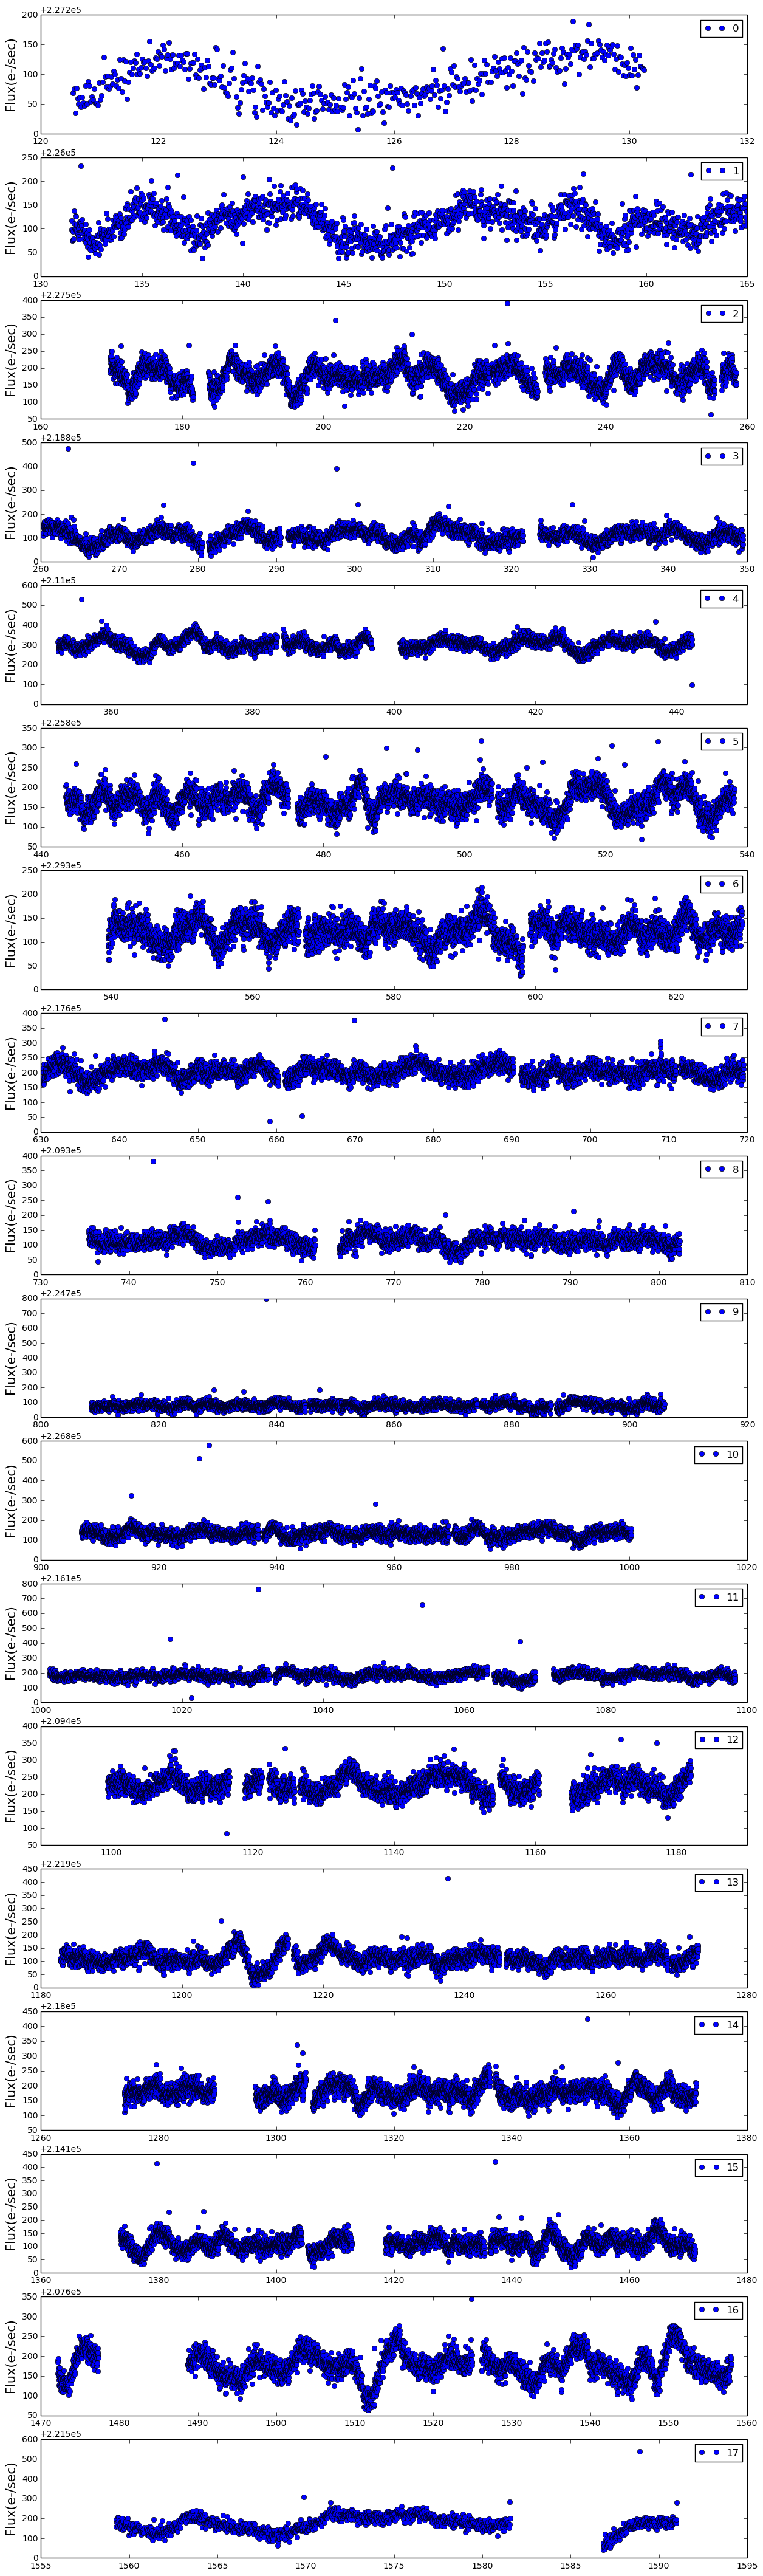

In [113]:
rows = len(quarters) #number of plots
columns =1 #number of columns for plot

plt.figure(1,figsize=(15, 3*rows))

plt.figure(1)
plt.title("Quarters")
for i in (quarters):# looping over all quarters for subplots
    plt.subplot(rows, columns, i+1)
    plt.plot(time[i],flux[i],'bo',label=i)
    plt.ylabel(y_label,fontsize=fontSize)
    
    plt.legend()
# plt.savefig('plots/KOI_265_AllQ_RAW2.PNG')
plt.show()

## Detrending Method, Running Average

Step 1: cleaning data, median smoothing to remove outliers

In [103]:
#number of pts smoothing over at each step
interval = 7
#new arrays for smoothed data
fq_median_smooth = []
tq_median_smooth = []
feq_median_smooth = []

for i in (quarters):
    t_q,f_q,fe_q = median_smooth(time[i],flux[i],interval,ferr[i])   
        
    #adding all values for quarter i
    fq_median_smooth.append(f_q)
    tq_median_smooth.append(t_q)
    feq_median_smooth.append(fe_q)

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:12: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:13: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:14: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


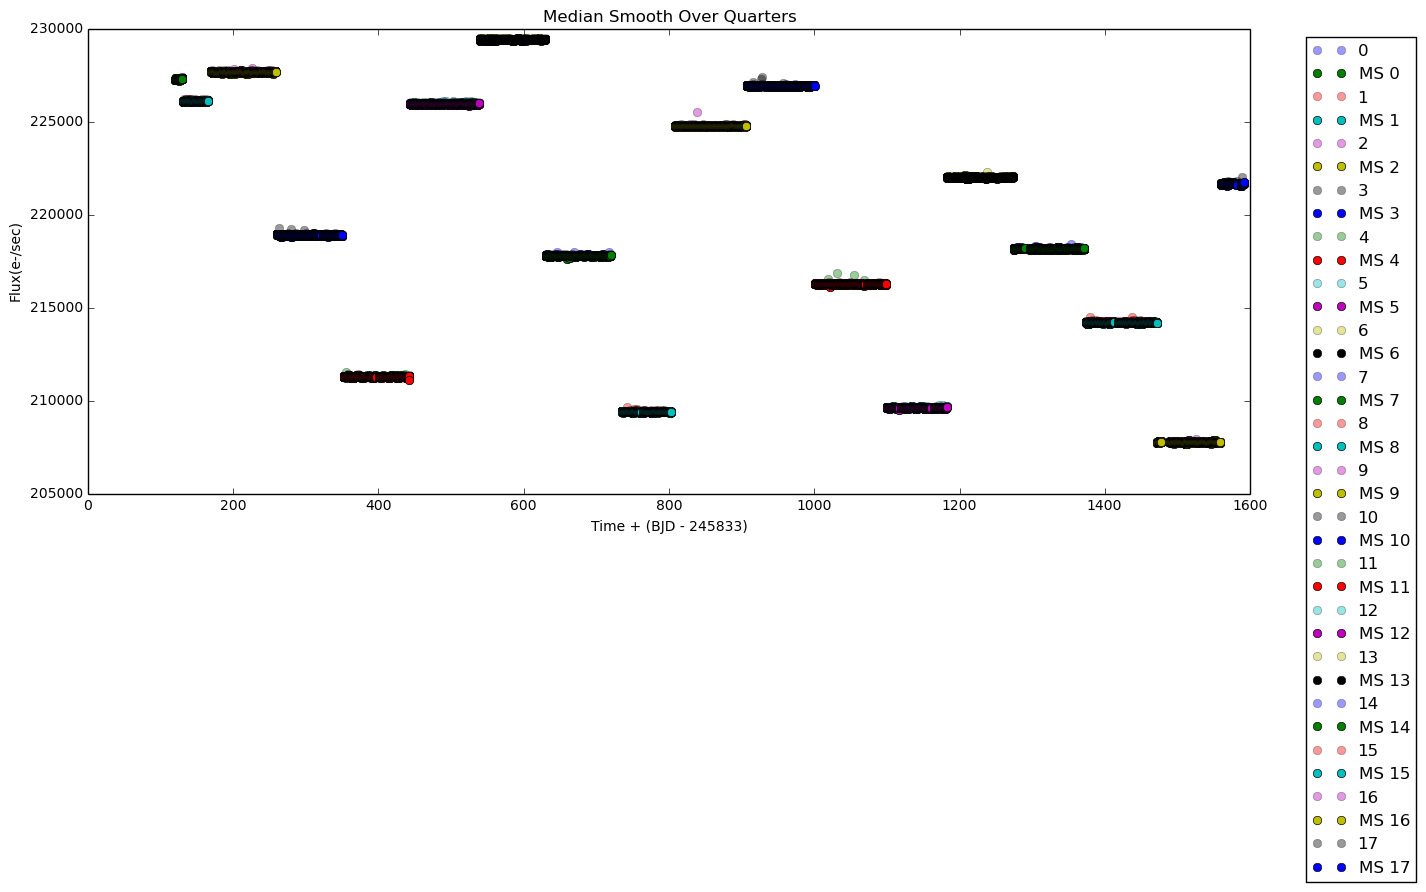

In [106]:
#Setting up plot for Detrending Method
smooth_label = 'Median Smooth Over Quarters'
plt.figure(figsize=(15,6))
plt.xlabel(x_label)
plt.ylabel(y_label)
plt.title(smooth_label)
for x in range(0,len(quarters)):
    q_plt = quarters[x]
    legend = 'MS %d' % q_plt
    
    plt.plot(time[q_plt],flux[q_plt],'o',label=q_plt,alpha= .4)
    plt.plot(tq_median_smooth[x],fq_median_smooth[x],'o',label=legend)
  
plt.legend(bbox_to_anchor=(1.15, 1))
plt.savefig('plots/KOI_265_AllQ_Median_Smooth.PNG')
# plt.xlim(400,600)

Seeing quarters individually

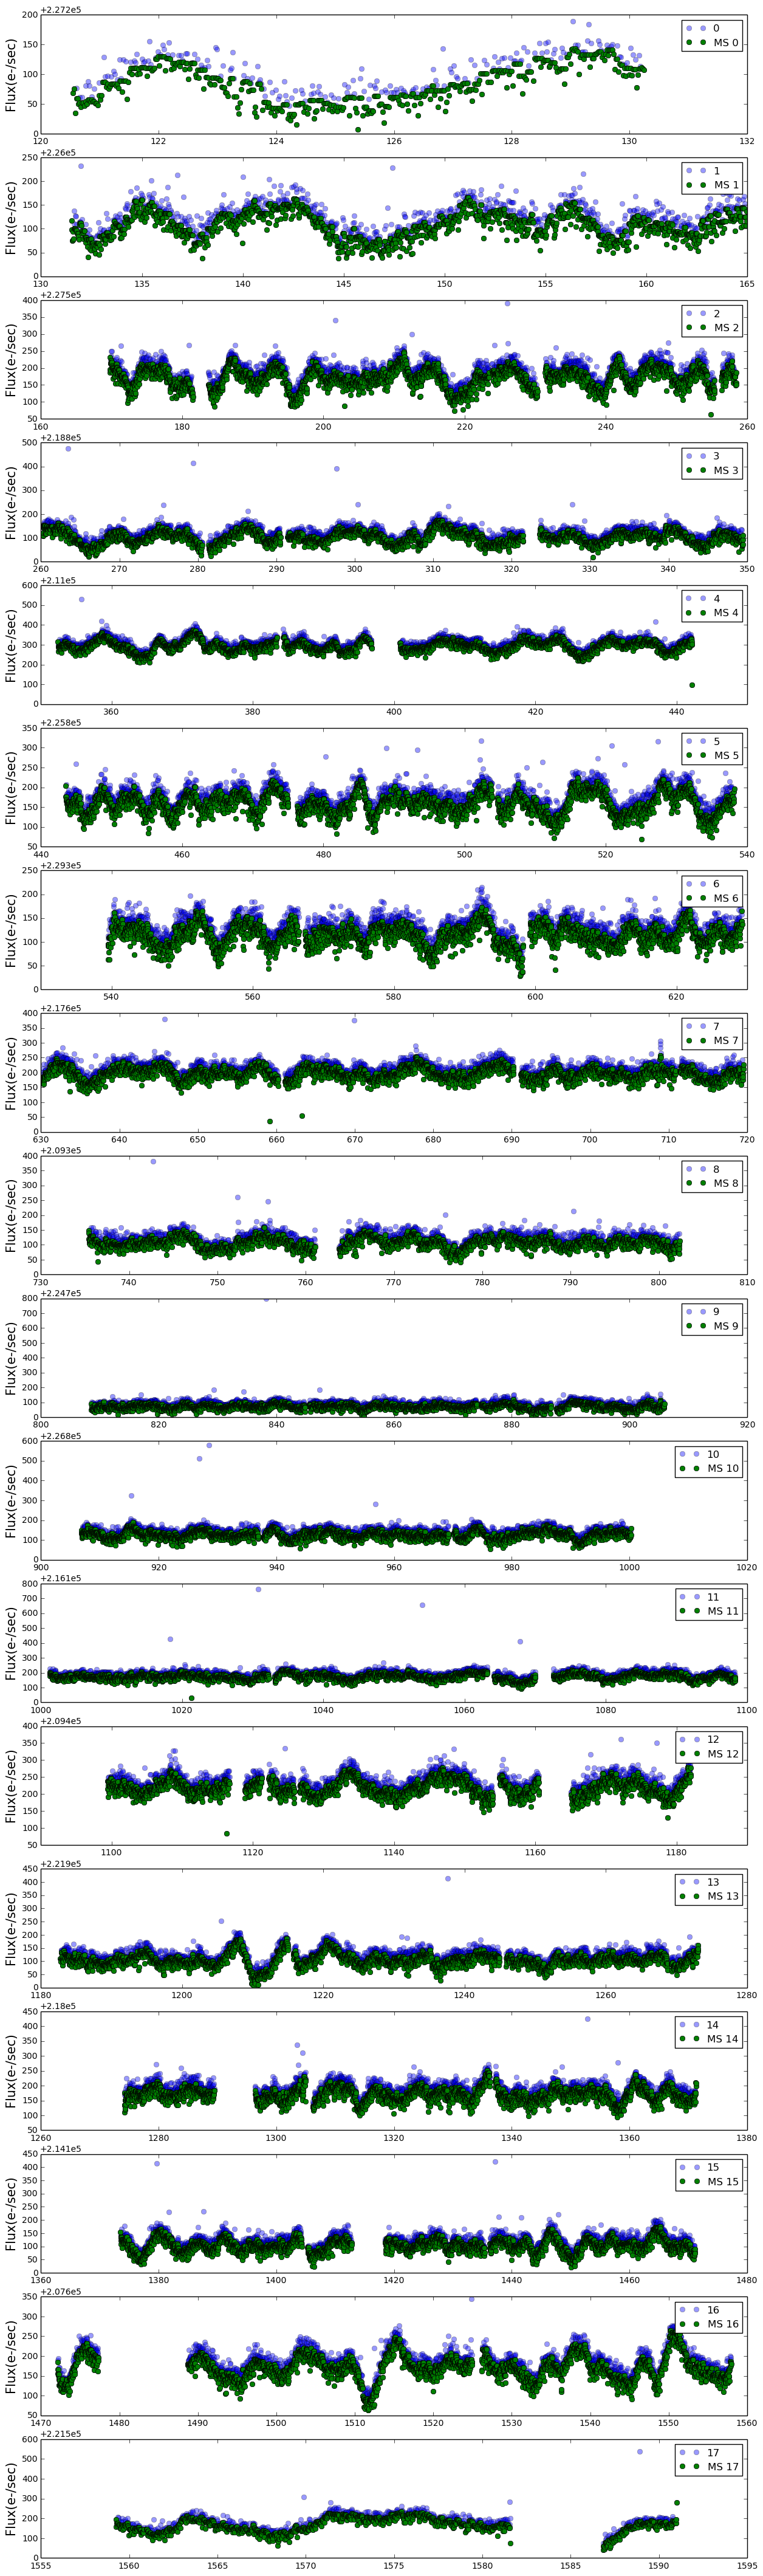

In [116]:
rows = len(quarters) #number of plots
columns =1 #number of columns for plot

plt.figure(1,figsize=(15, 3*rows))

plt.figure(1)
# plt.title('Quarter: Median Smooth',fontsize=fontSize)
for i in (quarters):# looping over all quarters for subplots
    legend = 'MS %d' % i
    plt.subplot(rows, columns, i+1)
    plt.plot(time[i],flux[i],'o',label=i,alpha= .4)
    plt.plot(tq_median_smooth[i],fq_median_smooth[i],'o',label=legend)

    plt.ylabel(y_label,fontsize=fontSize)
#     plt.title('Quarter: %d'%i,fontsize=fontSize)
    plt.legend()
# plt.savefig('plots/KOI_265_AllQ_Median_Smooth2.PNG')
# plt.show()

Step 2: Normalize data

In [117]:
#creating array to hold all normalized fluxes
fq_normalized = []
feq_normalized = []

#Normalizing all Median Smooth Quarters
for x in range(0,len(quarters)):
    f_median = statistics.median(fq_median_smooth[x])
    f_mean = np.mean(fq_median_smooth[x],dtype=np.float64)
    #make changes here if you want running average or median
    fq_normalized.append(fq_median_smooth[x]/f_mean)
    feq_normalized.append(feq_median_smooth[x]/f_mean) #flux error


#Normalizing all pre-smoothed quarters individually
f0_normalized = []
t0_normalized = []
fe0_normalized = []
for i in (quarters):
    time_check,flux_check,ferr_check = remove_nan(time[i],flux[i],ferr[i])
    median= (len(flux_check))/2
    f_median = statistics.median(flux_check)
    f_mean = np.mean(flux_check,dtype=np.float64)
    
    #make changes here if you want running average or median
    f0_normalized.append(flux_check/f_mean)
    fe0_normalized.append(ferr_check/f_mean) #flux error
    t0_normalized.append(time_check)

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:12: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:13: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:14: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


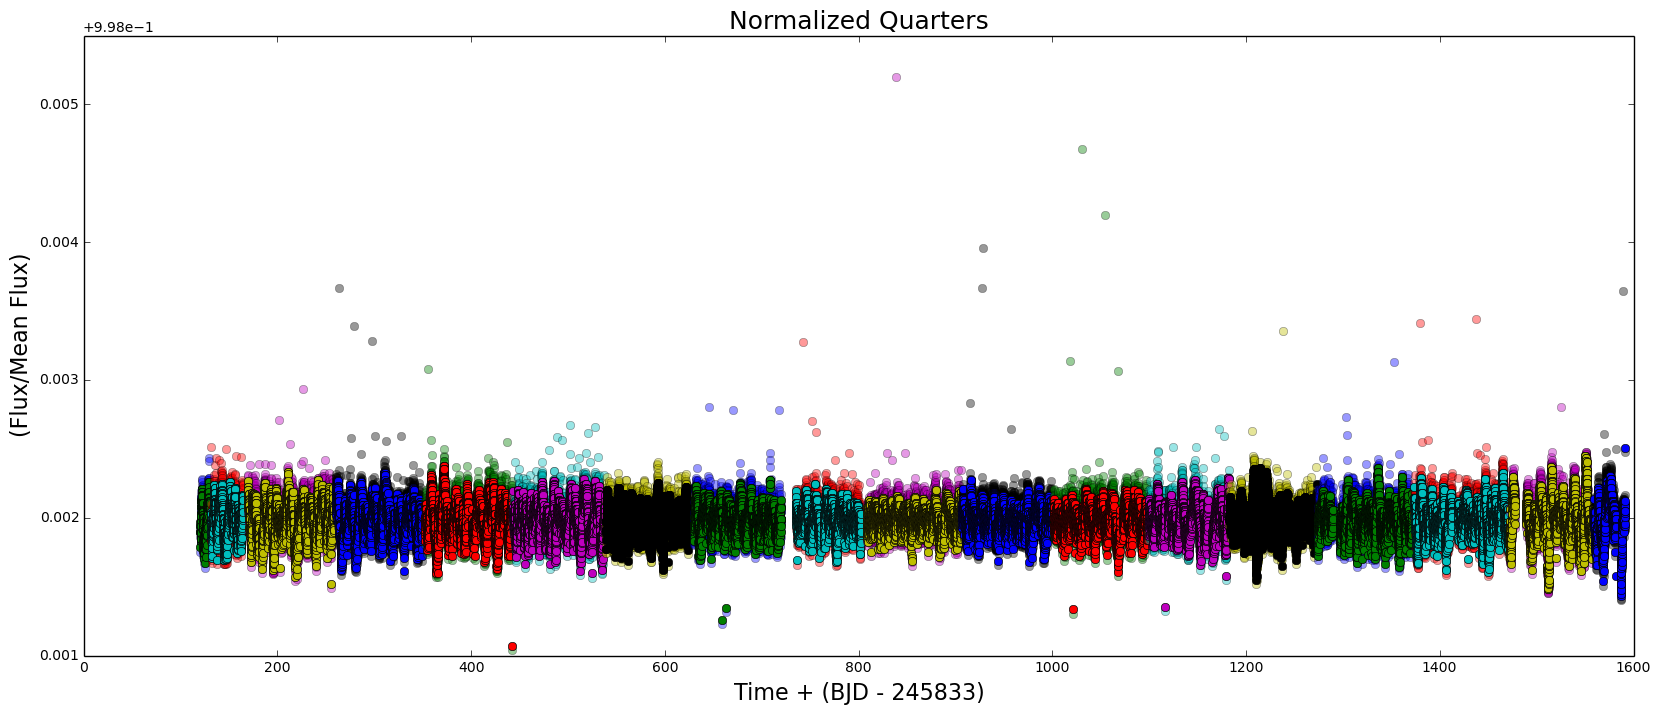

In [120]:
#label and title
normalized_ylabel = '(Flux/Mean Flux)'
normalized_title = 'Normalized Quarters'

#Plotting normalized quarters
plt.figure(figsize=(20,8))
plt.xlabel(x_label,size=16)
plt.ylabel(normalized_ylabel,size=16)
plt.title('Normalized Quarters',size=18)

#adding x and y data for plot
for x in range(0,len(quarters)):
    q_plt = quarters[x]
    
    plt.plot(t0_normalized[x],f0_normalized[x],'o',label='Original',alpha=.4)
    plt.plot(tq_median_smooth[x],fq_normalized[x],'o',label=q_plt)

# plt.legend(bbox_to_anchor=(1.15, 1))

Step 3: Detrend (Running Average or Median)

In [121]:
#combining all quarters into one array
f_normalized = np.hstack(fq_normalized)
ferr_normalized = np.hstack(feq_normalized)
t_no_outlier = np.hstack(tq_median_smooth)

t_detrend,f_detrend,ferr_detrend = detrend(t_no_outlier,f_normalized,ferr_normalized)

#if you want to detrend quarters individually
# fq_detrend = []
# tq_detrend = []
# for x in range(1,len(quarters)):
#     tq_d,fq_d = detrend(tq_median_smooth[x],fq_normalized[x])
#     fq_detrend.append(fq_d)
#     tq_detrend.append(tq_d)
# #     print x
# t_detrend = np.hstack(tq_detrend)
# f_detrend = np.hstack(fq_detrend)

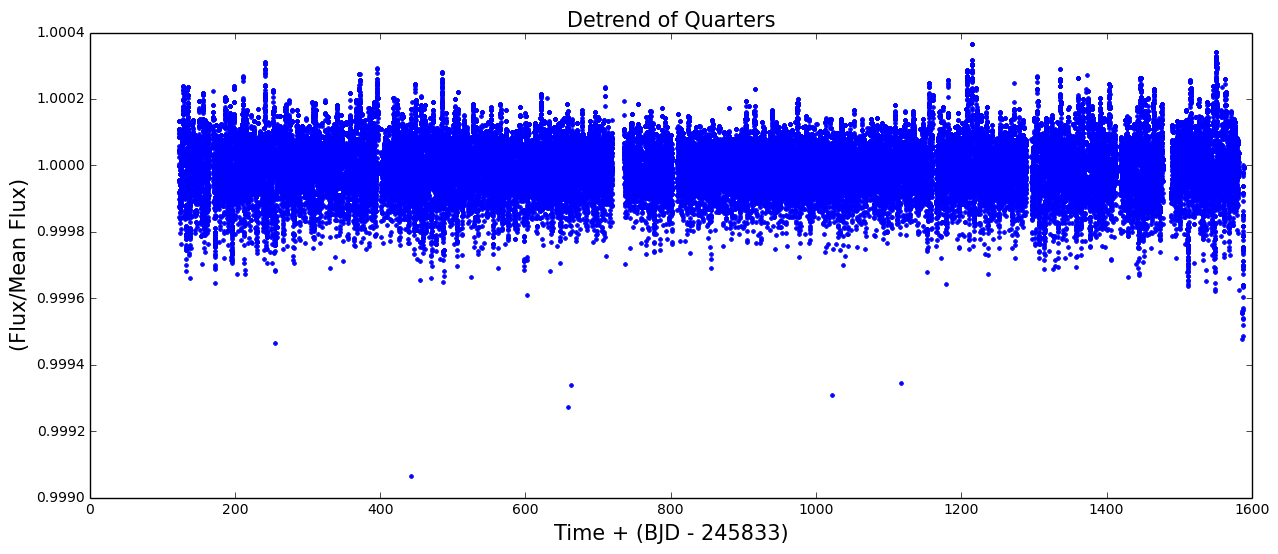

In [124]:
#title for detrend
detrend_title = 'Detrend of Quarters'

#plotting the detrended data
plt.figure(figsize=(15,6))
# plt.xlim(110,270)
# plt.ylim(1-.0002,1+.0002)
plt.title(detrend_title,fontsize=fontSize)
plt.xlabel(x_label,fontsize=fontSize)
plt.ylabel(normalized_ylabel,fontsize=fontSize)

plt.plot(t_detrend,f_detrend,'b.')

## Periodogram Lomb-Scargle and Box Least Squared

Finding optimal frequency:
 - Estimated peak width = 0.00429
 - Using 5 steps per peak; omega_step = 0.000858
 - User-specified period range:  0.2 to 11
 - Computing periods at 35975 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
period = 6.17530930777


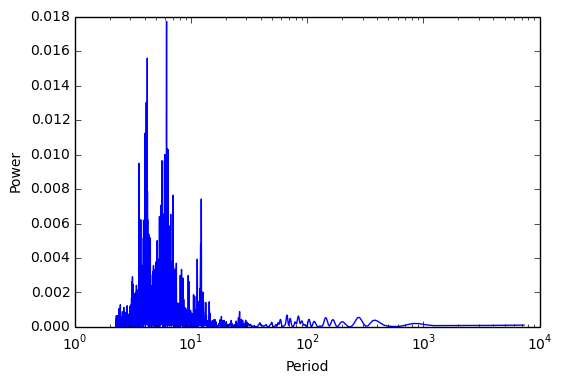

In [123]:
#1st argument: time data
#2nd argument: flux data
#3rd argument: minimum period
#4th argument: max period
#5th argument: time between data points
min_period = .2
max_period = (max(tq_median_smooth[1])-min(tq_median_smooth[1]))/3.
nyquist = .02 #30min flux samples
'Median Smooth and Detrend'
period1 = periodogram(t_detrend,f_detrend,min_period,max_period,nyquist)

BLS

In [125]:
# nf is the number of frequency bins to test,
# fmin is the minimum frequency to test,
# df is the frequency grid spacing,
# nb is the number of bins to use in the folded light curve
# qmi is the minimum transit duration to test, and
# qma is the maximum transit duration to test.

t_bls = t_detrend
f_bls = f_detrend

u = np.empty([1, len(t_bls)])#need to create an empty array of data size
v = np.empty([1, len(f_bls)])
nf = 10000
fmin = round(1./max_period,2) #freq = 1/period
df = 1./nf # So that 
nb = 500
qmi = 0.06 #.02 is about 30 mins
qma = 0.3  

results = bls.eebls(t_bls, f_bls, u, v, nf, fmin, df, nb, qmi, qma)
print 'Results:'
print 'Best_period:',results[1],'\nBest Power: ',results[2],'\nDepth:',results[3], \
'\nq(fractional transit duration): ',results[4],'\nin1:',results[5],'\nin2:',results[6]
print '\nCorrect Period = 3.568065'

Results:
Best_period: 3.56760613628 
Best Power:  1.10066988515e-05 
Depth: 4.51972816853e-05 
q(fractional transit duration):  0.0633133364098 
in1: 27 
in2: 58

Correct Period = 3.568065


11.1571164189
Best Period: 3.56760613628 
2nd Best Period: 6.17665225448 
3rd Best Period: 6.17283950617


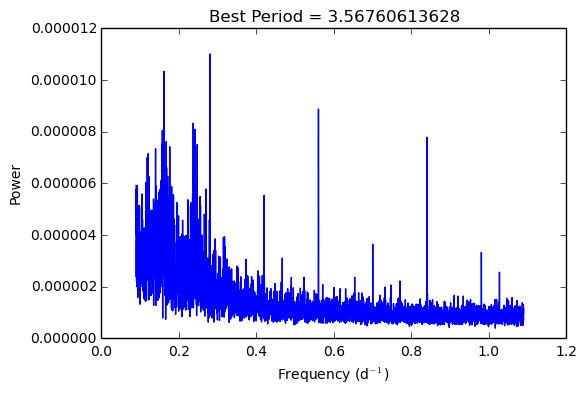

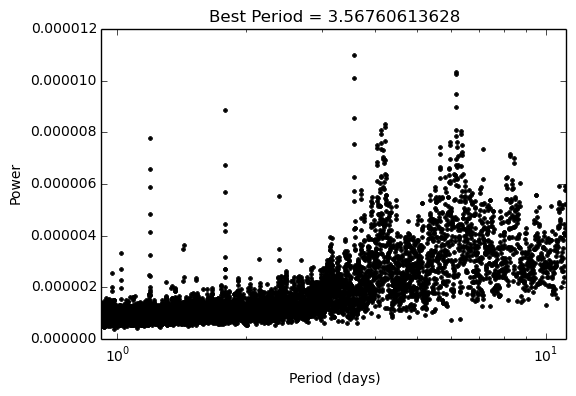

In [126]:
#Power of each Freq and period
fmax = round(1./min_period,2) #freq = 1/period
fmax = df*nf+fmin
steps = (fmax - fmin)/nf
freq = np.arange(fmin, fmax,steps)


per = 1./freq
per_max = results[0].argsort()[-3:][::-1]

plt.plot(freq, results[0])#results[0]-power
plt.title("Best Period = {0}".format(results[1]))
plt.xlabel(r"Frequency (d$^{-1}$)")
plt.ylabel("Power")

plt.figure()
plt.semilogx(per,results[0],'k.')
plt.title("Best Period = {0}".format(results[1]))
plt.xlabel(r"Period (days)")
plt.ylabel("Power")
print max_period
plt.xlim(0,max_period)

print 'Best Period:', per[per_max[0]],'\n2nd Best Period:', per[per_max[1]],'\n3rd Best Period:', per[per_max[2]]

(-10.0, 1475.2108901878819)

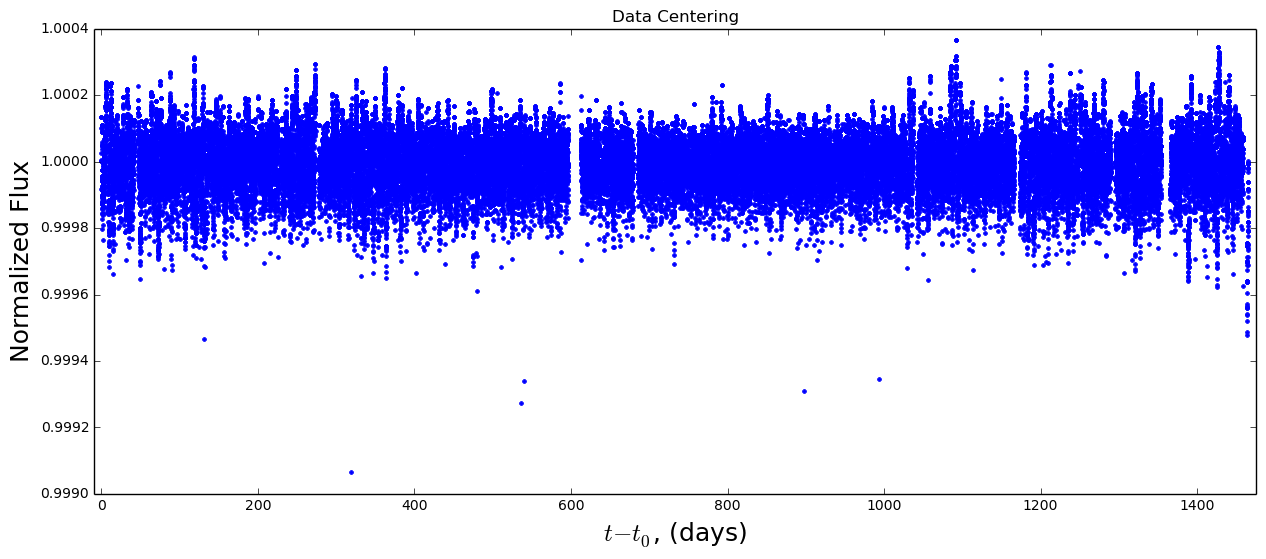

In [127]:
t1 = t_bls[0]
#subtracts t0 from all times
t_t0 = t_bls - t1
#avg. flux
avg_flux = np.mean(f_bls)

#each flux point subtracted from mean of flux
# v = f_bls - s

## adjustment
#Better cause it shows percentage of change
norm_fbls = f_bls/avg_flux

#plotting data
plt.figure(figsize=(15,6))
plt.plot(t_t0, norm_fbls, 'b.')
plt.title("Data Centering")
plt.xlabel(r"$t - t_0$, (days)",size=18)
plt.ylabel("Normalized Flux",size=18)
plt.xlim(np.min(t_t0) - 10 , np.max(t_t0) +10)

In [128]:
#converting period to freq
f0 = 1.0/(results[1]) #  freq = 1/T
nbin = nb # number of bin
n = len(t_bls)
ibi = np.zeros(nbin)
y = np.zeros(nbin)
ye = np.zeros(nbin)

phase = np.linspace(-0.5, 0.5, nbin) 

t_fold = []
#this loop folds the data for each phase
for i in range(n):
    ph = t_t0[i]*f0 #divides by period
    ph = ph - int(ph) # removes integer, ex. 5.2 ->> .2
    t_fold.append(ph-.5) #total data time fold
    
    #creates mean value of flux over time in a bin
    j = int(nbin*ph) # data to a bin 
    ibi[j] = ibi[j] + 1.0 # number of data in each bin
    y[j] = y[j] + norm_fbls[i] # sum of light in a bin
    
    #creates mean value of flux over time in a bin
    ye[j] = ye[j] + ferr_detrend[i] # sum of light in a bin
    
mean_bin = y/ibi
mean_binerr = ye/ibi

In [ ]:
#centering bins
#trouble when only looking at q5 and 6
diff_center =nbin*3/2  -(results[6]+results[5])/2 #distance from center, amount of bins shifted to the right
bin_shift = np.roll(mean_bin, diff_center) #centers bins
binerr_shift = np.roll(mean_binerr, diff_center) #centers bins

#fixing time shift for original data
shift_err = 90 #change to fix offset between bins and data, VERY IMPORTANT WHENEVER CHANGE QUARTER RANGE
diff_time = (diff_center-shift_err)*results[1]/nbin
t_shift = np.array(t_fold) + (diff_time-int(diff_time))

#rolling time values that go over .5
for x in range(0,len(t_shift)):
    if t_shift[x]>.5:
        t_shift[x] = t_shift[x]-1

In [ ]:
plt.figure(figsize=(15,6))
plt.plot(t_shift,norm_fbls,'o', alpha=0.1,label='Orig. Flux')
plt.errorbar(phase, bin_shift, yerr=binerr_shift,fmt='r.',label='Binned Flux',linewidth=1,alpha = 1)

plt.title("Period: {0} d  bin: {1}".format(results[1], nbin),size =18)
plt.xlabel(r"Phase ($\phi$)",size=16)
plt.ylabel(r"Mean value of $x(\phi)$ in a bin",size=16)
plt.legend()
plt.xlim(-.5,.5)
plt.ylim(1-.00025,1.00025)

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(t_shift,norm_fbls,'o', alpha=0.1,label='Orig. Flux')
plt.errorbar(phase, bin_shift, yerr=binerr_shift,fmt='r.',label='Binned Flux',linewidth=1,alpha = .6)
plt.xlim(-.2,.2)
plt.ylim(1-.00015,1.00015)

#box fit based on ingress, egress, and depth
fit = np.ones(nbin) # normalized value

#uses ingress(results[6]), and engress(results[5]), to model expected results
engress = nbin/2 + (results[6] - results[5])/2 # engress bin number
ingress = nbin/2 - (results[6] - results[5])/2 # ingress bin number
fit[ingress:engress] = 1-(results[3]) #inputting ingress and engress with found depth

print 'depth', results[3]


plt.plot(phase, fit,linewidth=3.0,label='BLS Fit',alpha=.8)
plt.title("Period: {0} d  bin: {1}".format(results[1], nbin))
plt.xlabel(r"Phase ($\phi$)")
plt.ylabel(r"Mean value of $x(\phi)$ in a bin")
plt.legend()

Guess of Radius based on Depth

In [ ]:
avg_err = sum(ferr_detrend)/sum(f_bls)
R_star = 1.18*R_sun # Star we are looking at
# depth = 1-np.abs(trough) #depth of trough
depth = results[3]
depth_max = results[3] + avg_err
R_planet = (R_star*np.sqrt(depth)) #finding radius of star
Rerr_planet = (R_star*np.sqrt(depth_max) -R_planet)#finding radius of star

print R_planet/R_earth,'±',Rerr_planet/R_earth,'Earth Radii'

print 'True answer: 1.29 Earth Radii'

## Modeling Fit of Light Curve

In [ ]:
#from D.K Sing
##https://arxiv.org/pdf/0912.2274.pdf
#Temperature of star about 6000k
#Log g = 4.50
u_linear = [0.5842]
u_quad = [0.3539, 0.2851]  
u_nonlinear3 = [1.5101 ,-1.2143 ,0.3714 ]
u_nonlinear4 = [0.5685, -0.0364, 0.5100, -0.3038]

In [ ]:
k = np.sqrt(depth)     #the planet-star radius ratio
t0 = 0.0                    #the transit center
p = results[1]              #the orbital period
# a = 15                    #the scaled semi-major axis, in units of star radius
i_rad = 0.5*np.pi               #the orbital inclination
i_deg = 90.
e = 0.001                   #the orbital eccentricity
w_rad = 0.5*np.pi               #longitude of periastron 
w_deg = 90.
u = u_quad                  #contains the quadratic limb darkening coefficients.
t = np.linspace(-0.5,.5,500)#Model time scale


T = results[4]*results[1] #total Transit time
T_full = (results[6] - results[5])*(results[1]/nbin) #full planet infront of star

#Using transit to get semi major axis
#equation from winn_transit.pdf, Joshua N. Winn
# a = ((np.pi/(k**.5))*(np.sqrt(T*T_full)/results[1])*(1+e*np.sin(w)/(np.sqrt(1-e**2))))**-1

#Kepler 3rd law to get semi major axis estimate
#scaled with star radius
a = (results[1]/365.)**(2/3.) / (R_star/ (149597870700.*units.m))

Fit for light curve using Batman Module

In [ ]:
#calculating Linear limb-darkening fit

params = batman.TransitParams()
params.t0 = t0                     #time of inferior conjunction
params.per = p                     #orbital period
params.rp = k                      #planet radius (in units of stellar radii)
params.a = a                       #semi-major axis (in units of stellar radii)
params.inc = i_deg                   #orbital inclination (in degrees)
params.ecc = e                     #eccentricity
params.w = w_deg                       #longitude of periastron (in degrees)
#https://arxiv.org/pdf/0912.2274.pdf
params.u = u_linear  #limb darkening coefficients [u1, u2]
params.limb_dark = "linear"       #limb darkening model

m_lin = batman.TransitModel(params, t)    #initializes model
linear_batman = m_lin.light_curve(params)          #calculates light curve

In [ ]:
#calculating quadratic limb-darkening fit
params.u = u_quad  #limb darkening coefficients [u1, u2]
params.limb_dark = "quadratic"       #limb darkening model

m_quad_all = batman.TransitModel(params, t_shift)    #initializes model, for all data
m_quad = batman.TransitModel(params, t)    #initializes model, for binned data
quad_batman = m_quad.light_curve(params)          #calculates light curve

In [ ]:
## Not Working
#calculating non-linear limb-darkening fit
# params.u = u_nonlinear4  #limb darkening coefficients [u1, u2]
# params.limb_dark = "nonlinear"       #limb darkening model

# m_nonlinear4 = batman.TransitModel(params, t)    #initializes model
# nonlinear4_batman = m_nonlinear4.light_curve(params)          #calculates light curve

In [ ]:
batman_all = m_quad_all.light_curve(params)          #calculates light curve
residuals_fbls = (norm_fbls)-(batman_all)

chi_squared = sum(((residuals_fbls)**2)/(batman_all))
print 'Chi-squared: ',chi_squared

#chi-squared minimization
err_sq = ferr_detrend

chi = sum((residuals_fbls/err_sq)**2)

print 'Chi-Minimized: ',chi

In [ ]:
plt.figure(figsize=(10,6))
plt.errorbar(phase, bin_shift, yerr=binerr_shift,fmt='r.',label='Binned Flux',alpha=.5)
# plt.plot(t_shift,norm_fbls,'o', alpha=0.1,label='Orig. Flux')
plt.plot(t, linear_batman,label='Linear')
plt.plot(t,quad_batman,label='Quadratic')
plt.xlabel(r"Phase ($\phi$)",size=15)
plt.ylabel("Relative flux")
plt.title("Batman Model Fit")
# plt.xlim(-results[4]/2-.01,results[4]/2+.01)
plt.xlim(-.15,.15)
plt.ylim(1-.00015,1.00015)
plt.legend()
plt.show()

Fit for light curve using PyTransit Module

In [ ]:
# m = MandelAgol()
# p0 = [k, u, t0, p, a, i_rad, e, w_rad]

# # model_pytran = m.evaluate(t, k, u, t0, p, a, i, e, w)
# model_pytran = m.evaluate(phase, p0[0], [p0[1][0],p0[1][1]], p0[2], p0[3], p0[4], p0[5], p0[6], p0[7])

In [ ]:
# plt.figure(figsize=(10,6))
# plt.plot(t,model_pytran,label='Quadratic')
# plt.errorbar(phase, bin_shift, yerr=binerr_shift,fmt='r.',label='Binned Flux',alpha=.5)
# plt.title("Period: {0} d  bin: {1}".format(results[1], nbin))
# plt.xlabel(r"Phase ($\phi$)")
# plt.title('PyTransit Model Fit')
# plt.ylabel(r"Mean value of $x(\phi)$ in a bin")
# plt.legend()

Testing out least square optimization for Mandel & Agol algorithm

In [ ]:
# p0 = [k, u_quad[0],u_quad[1], t0, p, a,i_deg, e, w_deg]

p0 = [k, u_quad[0],u_quad[1], a,i_deg,e,w_deg]
print 'Guess k: ', round(p0[0],6)
print 'Guess u1: ', round(p0[1],6)
print 'Guess u2: ', round(p0[2],6)
print 'Guess a: ', round(p0[3],6)
print 'Guess i: ', round(p0[4],6)
print 'Guess e: ', round(p0[5],6)
print 'Guess w: ', round(p0[6],6)


def residual_batman(p0, x, y):    
#     params.t0 = p0[3]                    #time of inferior conjunction
#     params.per = p0[4]                     #orbital period
    params.rp = p0[0]                      #planet radius (in units of stellar radii)
    params.a = p0[3]                       #semi-major axis (in units of stellar radii)
    params.inc = p0[4]                   #orbital inclination (in degrees)
    params.ecc = p0[5]                     #eccentricity
    params.w = p0[6]                       #longitude of periastron (in degrees)
    params.u = [p0[1],p0[2]]  #limb darkening coefficients [u1, u2]
    params.limb_dark = "quadratic"       #limb darkening model
    m_quad = batman.TransitModel(params, x)    #initializes model
    quad_batman = m_quad.light_curve(params)          #calculates light curve
    
    return y - quad_batman 

#optimizing based on fold flux
k_err = [.9*p0[0],10*p0[0]]
u1_err = [0,1]
u2_err = [0,1]
t0_err = [-.1,.1]
# p_err = [0.9999*p0[4],1.00001*p0[4]]
a_err = [0.9*p0[3],10*p0[3]]
i_err = [89,90]
e_err = [0,.1]
w_err = [89,90]

popt = optimize.least_squares(residual_batman, p0, args=(t_shift,norm_fbls),
                              bounds=([k_err[0],u1_err[0],u2_err[0],a_err[0],i_err[0],e_err[0],w_err[0]]
                                      ,[k_err[1],u1_err[1],u2_err[1],a_err[1],i_err[1],e_err[1],w_err[1]])) 

# batman_lq = m.evaluate(phase, popt[0],u, t0, p, popt[1],i, e, w)
params.rp = popt.x[0]                      #planet radius (in units of stellar radii)
# params.per = popt.x[4]                     #orbital period
params.a = popt.x[3]                       #semi-major axis (in units of stellar radii)
params.inc = p0[4]                   #orbital inclination (in degrees)
params.ecc = popt.x[5]                     #eccentricity
params.w = popt.x[6]                       #longitude of periastron (in degrees)
params.u = [popt.x[1],popt.x[2]]  #limb darkening coefficients [u1, u2]
m_quad_all = batman.TransitModel(params, t_shift)    #initializes model
m_quad = batman.TransitModel(params, phase)    #initializes model
batman_lq = m_quad.light_curve(params)          #calculates light curve

print'\noptimized params'
print 'k: ', round(popt.x[0],6)
print 'u1: ', round(popt.x[1],6)
print 'u2: ', round(popt.x[2],6)
print 'a: ', round(popt.x[3],6)
print 'i: ', round(popt.x[4],6) 
print 'e: ', round(popt.x[5],6) 
print 'w: ', round(popt.x[6],6) 

print

In [ ]:
batman_lq_all = m_quad_all.light_curve(params)          #calculates light curve
residuals_fbls = (norm_fbls)-(batman_lq_all)

chi_squared = sum(((residuals_fbls)**2)/(batman_lq_all))
print 'Chi-squared: ',chi_squared

#chi-squared minimization
err_sq = ferr_detrend


chi = sum((residuals_fbls/err_sq)**2)

print 'Chi: ',chi

In [ ]:
plt.figure(figsize=(15,9))
plt.errorbar(phase, bin_shift, yerr=binerr_shift,fmt='r.',label='Binned Flux',alpha=.9)
plt.plot(t_shift,norm_fbls, 'o',alpha=0.1,label='Orig. Flux')
plt.plot(phase,batman_lq,linewidth=2,label = 'Least-Square Fit')

plt.legend()
plt.xlim(-.2,.2)
plt.ylim(1-.00015,1.00015)

In [ ]:
plt.figure(figsize=(15,9))
plt.plot(t_shift,residuals_fbls,'o')
plt.xlim(-.2,.2)
# plt.ylim(1-.00015,1.00015)

In [ ]:
print popt.x[0]*R_star/R_earth

# Ignore Everything Below Here

In [ ]:
# m = MandelAgol()
# def residual_pytransit(params, x, y):
#     return y - m.evaluate(x, params[0],[params[2],params[3]], t0, p, params[1],i, e, w)

# #optimizing based on fold flux
# popt = optimize.least_squares(residual_pytransit, p0, args=(t_shift,norm_fbls),bounds=([.9*k,.9*a,0,0],[10*k,10*a,1,1]))

# pytran_lq = m.evaluate(phase, popt.x[0],[popt.x[2],popt.x[3]], t0, p, popt.x[1],i, e, w)

# plt.figure(figsize=(10,6))
# plt.errorbar(phase, bin_shift, yerr=binerr_shift,fmt='r.',label='Binned Flux',alpha=.9)
# plt.plot(t_shift,norm_fbls,'o', alpha=0.1,label='Orig. Flux')
# plt.plot(phase,pytran_lq,linewidth=2,label = 'a = %.5f, k = %.7f, u1 = %.5f, u2 = %.7f  '%(popt.x[1],popt.x[0],popt.x[2],popt.x[3]))
# plt.legend()
# plt.xlim(-.1,.1)
# plt.ylim(1-.00015,1.00015)

In [ ]:
# #calculating Linear limb-darkening fit
# params = batman.TransitParams()
# params.t0 = t0                     #time of inferior conjunction
# params.per = p                     #orbital period
# params.rp = k                      #planet radius (in units of stellar radii)
# params.a = a                       #semi-major axis (in units of stellar radii)
# params.inc = 90.                   #orbital inclination (in degrees)
# params.ecc = e                     #eccentricity
# params.w = 90.                       #longitude of periastron (in degrees)
# #https://arxiv.org/pdf/0912.2274.pdf
# params.u = u_linear  #limb darkening coefficients [u1, u2]
# params.limb_dark = "linear"       #limb darkening model
# print u_quad

In [ ]:
# M = ktransit.LCModel()
# M.add_star(
#         rho=2.5, # mean stellar density in cgs units
#         ld1=0.3539, # ld1--4 are limb darkening coefficients 
#         ld2=0.2851, # if only ld1 and ld2 are non-zero then a quadratic limb darkening law is used
#         #ld3=0.0, # if all four parameters are non-zero we use non-linear flavour limb darkening
#         #ld4=0.0, 
#         dil=0.0, # a dilution factor: 0.0 -> transit not diluted, 0.5 -> transit 50% diluted
#         zpt=1.0  # a photometric zeropoint, incase the normalisation was wonky
#         )
# M.add_planet(
#         T0=t0,     # a transit mid-time  
#         period=p, # an orbital period in days
#         impact=0.01, # an impact parameter
#         rprs=.0009,   # planet stellar radius ratio  
#         ecosw=0.0,  # eccentricity vector
#         esinw=0.0,
#         occ=0.0)    # a secondary eclipse depth in ppm

# M.add_planet() # you can add as many planets as you like (up to 10)

# M.add_data(
#      time=np.arange(-.5,.5,df),                                 # timestamps to evaluate the model on
#     itime=np.zeros_like(np.arange(-.5,.5,df))+df)      # integration time of each timestamp

# tmod = M.transitmodel # the out of transit data will be 0.0 unless you specify zpt

# plt.plot(M.time,tmod)
# plt.plot(phase, bin_shift, 'r.')

# # help (M.transitmodel)

## Using the python bls Function

In [ ]:
# # t_bls - time is an N-dimensional array of timestamps for the light curve,
# # f_bls - flux is the N-dimensional light curve array,
# # qmi is the minimum transit duration to test, and
# # qma is the maximum transit duration to test.
# # fmin is the minimum frequency to test,
# # df is the frequency grid spacing,
# # nf is the number of frequency bins to test,
# # nb is the number of bins to use in the folded light curve

# #same params as other bls above
# res = func_bls(t_bls, f_bls, qmi, qma, fmin, df, nf, nb)
# print "\ncorrect period: ", 3.568065


# print 'New Results'
# print "Best SR: ", res[0], "\nIngress: ", res[1], "\nEgress: ", res[2], "\nq: ", res[3], \
# "\nDepth: ", res[4], "\nPeriod: ", res[5], "\nSDE: ", res[6],
# print'\n\n'
# print 'Above RESULTS'
# print 'Best_period:',results[1],'\nBest Power: ',results[2],'\nDepth:',results[3], \
# '\nq(the fractional transit duration): ',results[4],'\nin1:',results[5],'\nin2:',results[6]

In [ ]:
# fmax = round(1./min_period,2) #freq = 1/period
# steps = (fmax - fmin)/nf
# freq = np.arange(fmin, fmax,steps)

# steps = (max_period - min_period)/nf
# per = np.arange(min_period, max_period,steps)
# plt.plot(freq, res[7], 'k.')#res[7]-power
# plt.title("SDE = {0}".format(res[6]))
# plt.xlabel(r"Frequency (d$^{-1}$)")
# plt.ylabel(r"$SR$")
# plt.figure()
# plt.plot(per, res[7], 'k.')
# plt.title("SDE = {0}".format(res[6]))
# plt.xlabel(r"Period (days)")
# plt.ylabel(r"$SR$")


In [ ]:
# t1 = t_bls[0]
# #subtracts t0 from all times
# u = t_bls - t1
# #avg. flux
# s = np.mean(f_bls)

# #each flux point subtracted from mean of flux
# # v = f_bls - s

# ## adjustment
# #Better cause it shows percentage of change
# v = f_bls/s

# #plotting data
# plt.figure(figsize=(15,6))
# plt.plot(u, v, 'b.')
# plt.title("Data Centering")
# plt.xlabel(r"$t - t_0$, (days)")
# plt.ylabel(r"$x(t) / \mu$, Flux")

In [ ]:
# #converting period to freq
# f0 = 1.0/(res[5]) #  freq = 1/T
# # f0 = 1.0/3.568065 #used to test real period
# nbin = nb # number of bin
# n = len(t_bls)
# ibi = np.zeros(nbin)
# y = np.zeros(nbin)
# phase = np.linspace(-0.5, 0.5, nbin) 

# t_fold = []
# #this loop folds the data for each phase
# for i in range(n):
#     ph = u[i]*f0 #divides by period
#     ph = ph - int(ph) # removes integer, ex. 5.2 ->> .2
#     t_fold.append(ph) #total data time fold
    
#     #creates mean value of flux over time in a bin
#     j = int(nbin*ph) # data to a bin 
#     ibi[j] = ibi[j] + 1.0 # number of data in each bin
#     y[j] = y[j] + v[i] # sum of light in a bin
    
# mean_bin = y/ibi

# diff_center =20+ nbin*3/2  -(res[2]+res[1])/2 #distance from center, amount of bins shifted to the right
# mean_bin = np.roll(mean_bin, diff_center) #centers bins
# t_fold = np.roll(t_fold, diff_center) #centers time

In [ ]:
# plt.figure(figsize=(15,6))
# plt.plot(t_fold-.5,v,'o', alpha=0.1)
# plt.plot(phase, mean_bin, 'r.')
# plt.title("Period: {0} d  bin: {1}".format(res[5], nbin))
# plt.xlabel(r"Phase ($\phi$)")
# plt.ylabel(r"Mean value of $x(\phi)$ in a bin")
# # plt.xlim(-.1,.1)
# # plt.ylim(1-.0001,1.0001)

In [ ]:
# plt.plot(phase, mean_bin, 'r.')

# #bls fit
# fit = np.ones(nbin) # normalized value
# #res[8] = high, res [9] = low
# #uses ingress(res[1]), and engress(res[2]), to model expected results
# engress = nbin/2 + (res[2] - res[1])/2 # engress bin number
# ingress = nbin/2 - (res[2] - res[1])/2 # ingress bin number
# fit[ingress:engress] = 1-res[4] #inputting ingress and engress with found depth

# print 'depth', res[4]

# plt.plot(phase, fit)
# plt.title("Period: {0} d  bin: {1}".format(res[5], nbin))
# plt.xlabel(r"Phase ($\phi$)")
# plt.ylabel(r"Mean value of $x(\phi)$ in a bin")

## Radius of Planet

In [ ]:
# R_star = 1.35*R_sun # Star we are looking at
# # depth = 1-np.abs(trough) #depth of trough
# depth = res[4]
# R_planet = R_star*np.sqrt(depth) #finding radius of star
# print R_planet/R_earth, 'Earth Radii'
# print 'True answer: 1.29 Earth Radii'